In [1]:
from learners.s_learner import make_slearner
import tensorflow as tf 
from tensorflow import keras
import numpy as np
from dataloader import load_IHDP_data
from visualizations import plot_cates

In [2]:
data = load_IHDP_data(training_data='./ihdp_npci_1-100.train.npz',testing_data='./ihdp_npci_1-100.test.npz')

#concatenate t so we can use it as input
xt = np.concatenate([data['x'], data['t']], 1)

### S-Learner

In [4]:
loss_fn = tf.keras.losses.MeanSquaredError() #specify the loss

val_split=0.2
batch_size=64
verbose=1
i = 0
tf.random.set_seed(i)
np.random.seed(i)

sgd_callbacks = [
        keras.callbacks.TerminateOnNaN(),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, min_delta=0.), 
        keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                          min_delta=0., cooldown=0, min_lr=0),
    ]
#optimzier hyperparameters
sgd_lr = 1e-5
momentum = 0.9

In [9]:
s_learner = make_slearner(0.01, 200, 3)

s_learner.compile(optimizer= keras.optimizers.SGD(learning_rate=sgd_lr, momentum=momentum, nesterov=True),
                    loss=loss_fn,
                    metrics=loss_fn)

#'ys' transformed y
s_learner.fit(x=xt,y=data['ys'],
                validation_split=.2,
                epochs=300,
                batch_size=64,
                callbacks=sgd_callbacks,
                verbose=0)
print("Done")
print(s_learner.summary())

Done
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 200)               5400      
                                                                 
 dense_23 (Dense)            (None, 200)               40200     
                                                                 
 dense_24 (Dense)            (None, 200)               40200     
                                                                 
 dense_25 (Dense)            (None, 100)               20100     
                                                                 
 dense_26 (Dense)            (None, 100)               10100     
                                                                 
 dense_27 (Dense)            (None, 1)                 101       
                                                                 
Total params: 116,101
Trainable params: 116,101
N

24/24 [==============================] - 0s 2ms/step
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)

SQRT PEHE: 3.4734552
Estimated ATE (True is 3.854): 0.731 



Error CATE Estimates: RED
Individualized CATE Estimates: BLUE
Individualized CATE True: GREEN


(3.4734552, 3.2687371969223022)

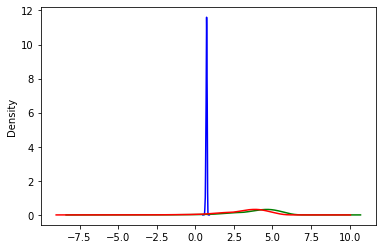

In [10]:
import pandas as pd
import numpy as np
#create fake ones and zeros to feed network
zeros=np.expand_dims(np.zeros(data['x'].shape[0]),1)
ones=np.expand_dims(np.ones(data['x'].shape[0]),1)
x_untreated = np.concatenate([data['x'], zeros], 1)
x_treated = np.concatenate([data['x'], ones], 1)
y0_pred_slearner=s_learner.predict(x_untreated)
y1_pred_slearner=s_learner.predict(x_treated)

plot_cates(y0_pred_slearner,y1_pred_slearner,data)

### T-Learner

In [3]:
from learners.t_learner import make_tlearner, regression_loss

t_learner = make_tlearner(25, .01, 100)

val_split=0.2
batch_size=64
verbose=1
i = 0
tf.random.set_seed(i)
np.random.seed(i)
yt = np.concatenate([data['ys'], data['t']], 1) #we'll use both y and t to compute the loss


sgd_callbacks = [
        keras.callbacks.TerminateOnNaN(),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, min_delta=0.), 
        #40 is Shi's recommendation for this dataset, but you should tune for your data 
        keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                          min_delta=0., cooldown=0, min_lr=0),
    ]
#optimzier hyperparameters
sgd_lr = 1e-5
momentum = 0.9
t_learner.compile(optimizer=keras.optimizers.SGD(learning_rate=sgd_lr, momentum=momentum, nesterov=True),
                    loss=regression_loss,
                    metrics=regression_loss)

t_learner.fit(x=data['x'],y=yt,
                callbacks=sgd_callbacks,
                validation_split=val_split,
                epochs=300,
                batch_size=batch_size,
                verbose=0)
print("DONE!")
print(t_learner.summary())


2022-11-30 14:17:40.256660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Epoch 87: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 97: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 116: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 121: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 126: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 131: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-07.

Epoch 136: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.

Epoch 145: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-08.

Epoch 154: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.

Epoch 159: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-09.

Epoch 164: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-09.

Epoch 169: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-09.

Epoch 174: ReduceLROnPlateau reducing learning rate to 

24/24 [==============================] - 0s 1ms/step
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)

SQRT PEHE: 0.77170753
Estimated ATE (True is 3.854): 3.635 



Error CATE Estimates: RED
Individualized CATE Estimates: BLUE
Individualized CATE True: GREEN


(0.77170753, 0.36472463607788086)

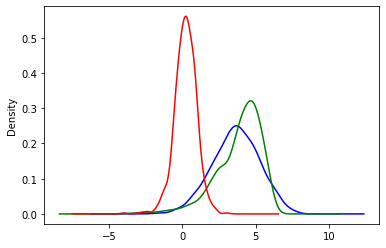

In [4]:
concat_pred=t_learner.predict(data['x'])
#dont forget to rescale the outcome before estimation!
y0_pred_tlearner,y1_pred_tlearner = concat_pred[:, 0].reshape(-1,1),concat_pred[:, 1].reshape(-1,1)
plot_cates(y0_pred_tlearner,y1_pred_tlearner,data)